# Synthetic data testing

## Setup

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

In [2]:
yy, xx = np.mgrid[-2*np.pi:2*np.pi:149j, -2*np.pi:2*np.pi:149j]

In [47]:
theta = np.pi/3
scale = 2
z = np.cos((xx * np.sin(theta) + yy * np.cos(theta))*scale)

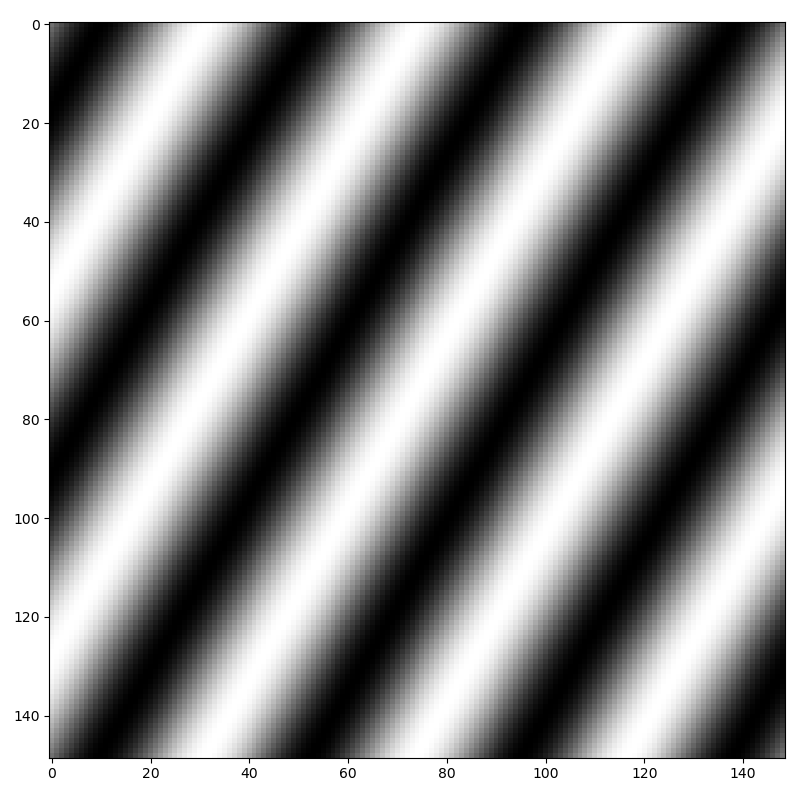

In [48]:
F, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(z, cmap='gray')
F.tight_layout()

## FRT Testing

In [15]:
from frat import frt

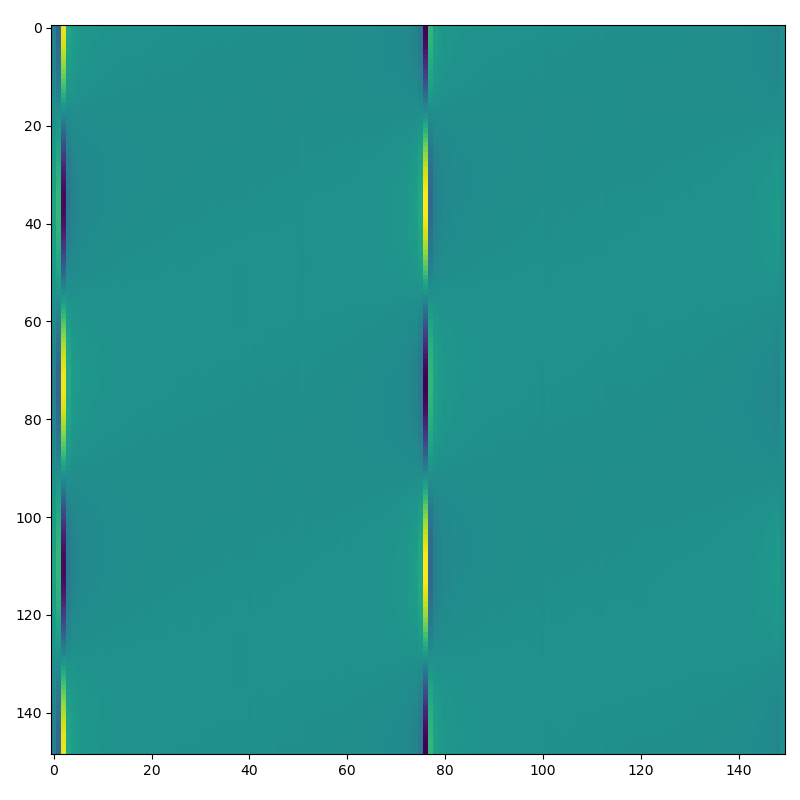

In [49]:
syn_frt = frt()
frt_sino = syn_frt.fit_transform(z)

F, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(frt_sino)
F.tight_layout()

In [30]:
cmaps[1]

'cividis'

[-2.0, 1.0]
1.1071487177940904
1.0471975511965976


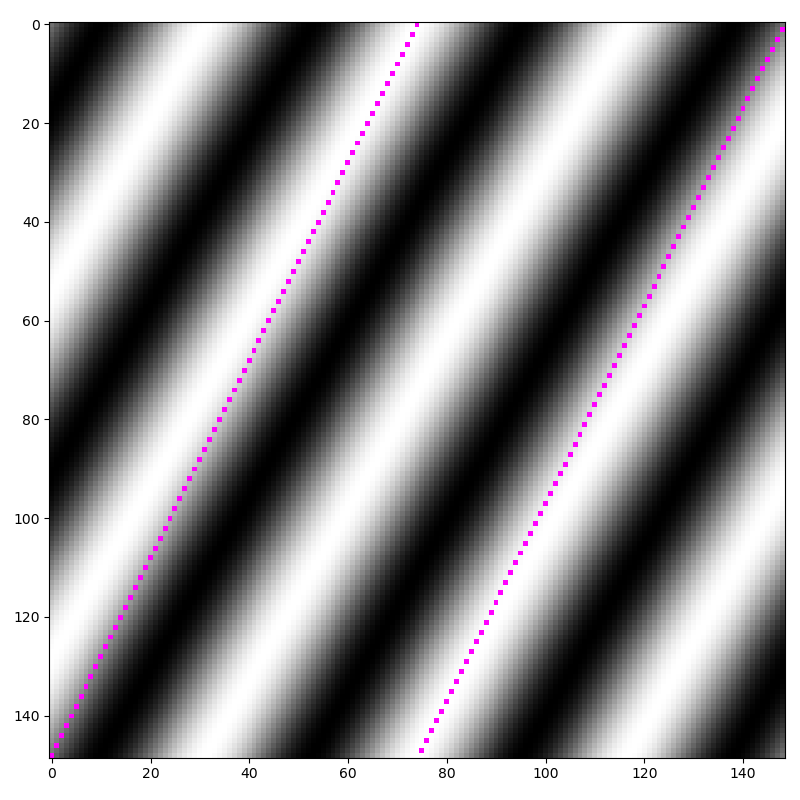

In [51]:
# For pi/3 angle with scale = 2, n_vec 2 and 76 are of interest
# For pi/3 angle with scale = 3, n_vec 101 is the primary of interest, with n_vecs 2, 51, and 52 as secondary 
F, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(z, cmap='gray')

check = 2
n_vec = syn_frt.n_vecs[check]
print(n_vec)
print(np.arctan(-n_vec[0]/n_vec[1]))
# print(np.pi - np.arctan(-n_vec[0]/n_vec[1]))
print(theta)
lines_ex = np.empty((149, 149))
# first_col = np.arange(149)[::-1]
first_col = np.zeros(149)
first_col[-1] = 1
if n_vec[1] != 0:
    lines_ex[:, 0] = first_col
    x_step = n_vec[1]
    y_step = -n_vec[0]
    for i in range(1, 149):
        lines_ex[:, int(i * x_step) % 149] = np.roll(first_col, -int(i * y_step) % 149)
ax.imshow(lines_ex, alpha=lines_ex, cmap='cool')

F.tight_layout()

In [ ]:
-101x + 1y + 0 = 0

## Arbitrary multiplication

In [8]:
class ImageScaler(object):
    
    def __init__(self, with_mean=True, with_std=True, copy=True):
        self.with_mean = with_mean
        self.with_std = with_std
        self.copy = copy
        
    def fit(self, X, y=None):
        self.mean_ = X.mean()
        self.std_ = X.std()
        return None
        
    def transform(self, X, copy=None):
        try:
            self.mean_
            self.std_
        except NameError:
            print('Must run .fit method first')
        if copy is None:
            copy = self.copy
        if copy:
            X= X.copy()
        if self.with_mean:
            X -= self.mean_
        if self.with_std:
            X /= self.std_
        return X

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
    def inverse_transform(self, X, y=None):
        try:
            self.mean_
            self.std_
        except NameError:
            print('Must run .fit method first')
        if self.with_std:
            X *= self.std_
        if self.with_mean:
            X += self.mean_

In [9]:
def arb_mult(img, f, theta, a, size):
    im_scaler = ImageScaler(with_std=True)
    yy, xx = np.mgrid[-1:1:size*1j, -1:1:size*1j]
    zz = (1/np.sqrt(a))*f((xx*np.sin(theta) + yy*np.cos(theta))/a)
    zz = im_scaler.fit_transform(zz)
    
    # F, ax = plt.subplots(1, 1, figsize=(4, 4))
    # ax.imshow(zz)
    # F.tight_layout()
    
    results_mat = np.empty((img.shape[0] - size, img.shape[1] - size))
    for x in range(img.shape[1] - size):
        for y in range(img.shape[0] - size):
            results_mat[y, x] = np.mean(zz * im_scaler.fit_transform(img[y:y+size, x:x+size]))
    return results_mat

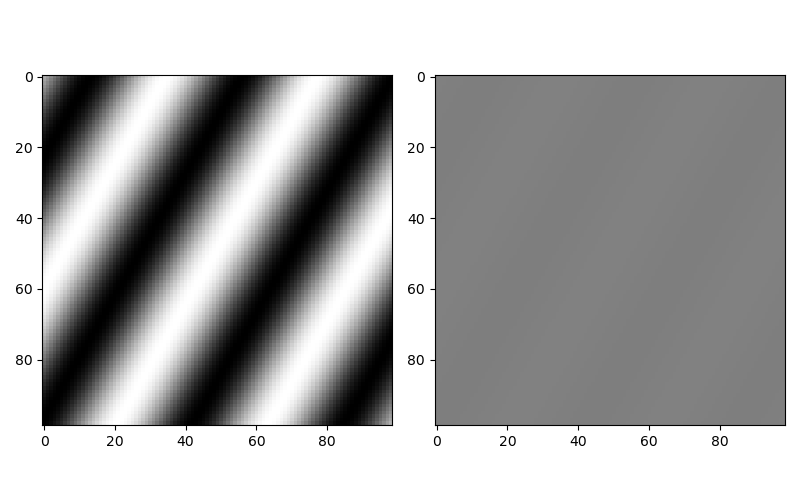

In [10]:
F, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(z[25:-25, 25:-25], cmap='gray')
ax[1].imshow(arb_mult(z, np.cos, 5*np.pi/6, 0.2, 50), cmap='gray', clim=(-2, 2))
F.tight_layout()

In [11]:
scales = [1/2**(x-6) for x in range(12)]
angles = [i * np.pi / 12 for i in range(12)]
full_analysis = np.empty((z.shape[0] - 50, z.shape[1] - 50, len(scales), len(angles)))
for i, scale in enumerate(scales):
    for j, angle in enumerate(angles):
        full_analysis[:, :, i, j] = arb_mult(z, np.cos, angle, scale, 50)

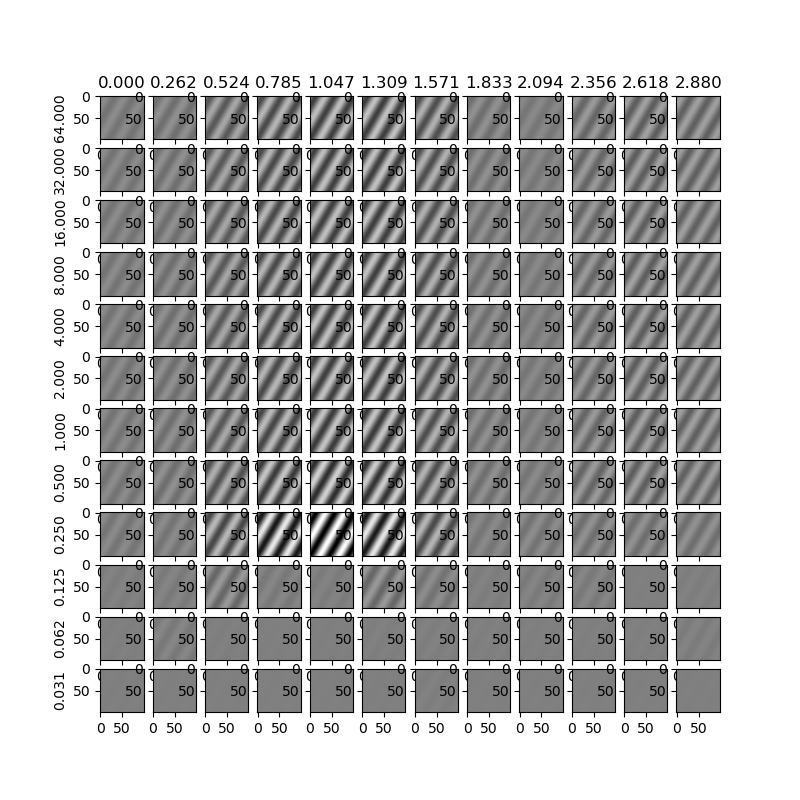

In [12]:
F, ax = plt.subplots(len(scales), len(angles), figsize=(8, 8))
vmax = full_analysis.max()
vmin = full_analysis.min()
c_lim = np.max((np.abs(vmax), np.abs(vmin)))
for i, scale in enumerate(scales):
    ax[i, 0].set_ylabel(f'{scale:.3f}')
    for j, angle in enumerate(angles):
        ax[0, j].set_title(f'{angle:.3f}')
        ax[i, j].imshow(full_analysis[:, :, i, j], cmap='gray', clim=(-c_lim, c_lim))